# Cross-dataset Insights and Innovation Opportunities

## Import data

In [141]:
import re
import pandas as pd
import spacy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [142]:
# Load English language model
nlp = spacy.load("en_core_web_sm")

def parse_faq_file(file_path, source):
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Use regular expressions to find all Q/A pairs
    pattern = re.compile(r'# Q: (.*?)\nA: (.*?)\n', re.DOTALL)
    matches = pattern.findall(content)
    
    # Convert matches to a list of dictionaries with an additional source field
    faq_list = [{'question': q, 'answer': a, 'source': source} for q, a in matches]
    return faq_list

# Define the relative file paths
file_path_patent = '../faq_patent.md'
file_path_media = '../faq_media.md' 

# Parse the files with source labels
faq_patent_list = parse_faq_file(file_path_patent, 'patent')
faq_media_list = parse_faq_file(file_path_media, 'media')

# Convert list to a pandas DataFrame
faq_patent = pd.DataFrame(faq_patent_list)
faq_media = pd.DataFrame(faq_media_list)

# Output the DataFrame
print(faq_patent.head())
print(faq_media.head())

                                            question  \
0                    What does "Disclosed" refer to?   
1  Is the energy recycling method suitable for al...   
2  What factors affect the growth of plants in di...   
3    What are the key features of the utility model?   
4  What components are typically found on the fro...   

                                              answer  source  
0                An adaptable DC-AC inverter system.  patent  
1  Yes, the energy is recycled, and the method is...  patent  
2  The growth of plants is influenced by a range ...  patent  
3  The utility model has reasonable design and ob...  patent  
4  The front side of the water tank is typically ...  patent  
                                            question  \
0  What process does the facility use to convert ...   
1  As of what year did Louisiana have approximate...   
2  What impact will energy storage have on solar ...   
3  Will private developers be building solar plan...   
4  Wh

## Extract themes


In [143]:
# Function to extract themes using NMF
def extract_themes(df, text_column, n_topics=10):
    texts = df[text_column].tolist()
    vectorizer = TfidfVectorizer(stop_words='english')
    vectors = vectorizer.fit_transform(texts)
    nmf = NMF(n_components=n_topics, random_state=42)
    nmf.fit(vectors)
    terms = vectorizer.get_feature_names_out()
    themes = []
    for topic_idx, topic in enumerate(nmf.components_):
        top_terms = [terms[i] for i in topic.argsort()[:-11:-1]]
        weight_sum = topic.sum()
        themes.append((top_terms, weight_sum))
    return themes

# Combine question and answer text
faq_patent['combined_text'] = faq_patent['question'] + " " + faq_patent['answer']
faq_media['combined_text'] = faq_media['question'] + " " + faq_media['answer']

# Extract themes for both DataFrames
patent_themes = extract_themes(faq_patent, 'combined_text')
media_themes = extract_themes(faq_media, 'combined_text')

# Output the themes
print("Patent Themes and Weights:")
for theme in patent_themes:
    print(f"Theme: {theme[0]}, Weight: {theme[1]}")

print("\nMedia Themes and Weights:")
for theme in media_themes:
    print(f"Theme: {theme[0]}, Weight: {theme[1]}")

Patent Themes and Weights:
Theme: ['energy', 'solar', 'power', 'waste', 'indoor', 'electricity', 'harness', 'electric', 'generation', 'assembly'], Weight: 15.544189321856454
Theme: ['water', 'tank', 'typically', 'flow', 'pump', 'collecting', 'feed', 'eutrophication', 'gate', 'discharged'], Weight: 9.074562626663251
Theme: ['protection', 'manhole', 'impact', 'environmental', 'carbon', 'step', 'low', 'external', 'process', 'device'], Weight: 10.01226129019216
Theme: ['battery', 'invention', 'connected', 'main', 'describes', 'management', 'described', 'order', 'reversing', 'implications'], Weight: 9.551374957463915
Theme: ['wind', 'generating', 'set', 'energy', 'torque', 'improved', 'farm', 'offshore', 'goal', 'device'], Weight: 8.494808431610153
Theme: ['model', 'utility', 'treatment', 'sewage', 'street', 'relates', 'technical', 'field', 'rural', 'low'], Weight: 6.895773681770319
Theme: ['purpose', 'equipment', 'data', 'hydraulic', 'transmission', 'storage', 'cloud', 'using', 'submarine'

c:\Users\Viktor\switchdrive\Master Data Science\Semester 4\CLT\Project\clt-cleantech-project\.venv\lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [144]:
def extract_themes_with_sklearn(faq_df, num_topics=10):
    # Combine question and answer into a single document
    documents = faq_df['question'] + " " + faq_df['answer']
    
    # Initialize TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    
    # Fit and transform the documents
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
    
    # Initialize NMF
    nmf_model = NMF(n_components=num_topics, random_state=42)
    
    # Fit the model
    nmf_model.fit(tfidf_matrix)
    
    # Extract feature names (words)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Initialize an empty list to store themes
    themes = []
    
    # Iterate over each topic
    for topic_idx, topic in enumerate(nmf_model.components_):
        # Sort the words in the topic by their importance (weight)
        top_words_idx = topic.argsort()[:-11:-1]
        
        # Get the weights of the top words
        weights = topic[top_words_idx]
        
        # Get the top words themselves
        top_words = [feature_names[i] for i in top_words_idx]
        
        # Append the theme (topic) along with its top words and weights
        themes.append({'theme': f'Topic {topic_idx}', 'top_words': top_words, 'weights': weights})
    
    # Convert themes to DataFrame
    themes_df = pd.DataFrame(themes)
    
    return themes_df

# Extract themes using sklearn
patent_themes_sklearn = extract_themes_with_sklearn(faq_patent)
media_themes_sklearn = extract_themes_with_sklearn(faq_media)


# Output the themes
print(patent_themes_sklearn.head())
print(media_themes_sklearn)



     theme                                          top_words  \
0  Topic 0  [solar, does, energy, electric, harness, elect...   
1  Topic 1  [water, pump, hole, tank, structure, control, ...   
2  Topic 2  [battery, main, connected, purpose, connection...   
3  Topic 3  [protection, impact, body, process, low, exter...   
4  Topic 4  [purpose, equipment, transmission, hydraulic, ...   

                                             weights  
0  [1.0821271060631297, 0.5745152581057941, 0.521...  
1  [1.0419488761568922, 0.3901256808755803, 0.291...  
2  [1.2555676527510309, 0.6918515439278491, 0.438...  
3  [1.00165989193507, 0.5368542730092258, 0.46283...  
4  [0.8097652667029559, 0.7416859879417389, 0.477...  
     theme                                          top_words  \
0  Topic 0  [energy, solar, projects, does, time, developm...   
1  Topic 1  [lightsource, bp, agreement, purchase, power, ...   
2  Topic 2  [results, japan, final, auction, project, capa...   
3  Topic 3  [pv, fr

## Compare themes

### Separate words that are in both datasets and those only in one

In [145]:
def compare_topic_overlap(patent_themes, media_themes):

    # Extract the set of top words for each dataset
    patent_top_words = set(word for theme in patent_themes['top_words'] for word in theme)
    media_top_words = set(word for theme in media_themes['top_words'] for word in theme)
    
    # Find common top words
    common_top_words = patent_top_words.intersection(media_top_words)
    
    # Find top words unique to each dataset
    patent_only_top_words = patent_top_words - common_top_words
    media_only_top_words = media_top_words - common_top_words
    
    return common_top_words, patent_only_top_words, media_only_top_words

common_top_words, patent_only_top_words, media_only_top_words = compare_topic_overlap(patent_themes_sklearn, media_themes_sklearn)

print("Common Top Words:")
print(common_top_words)
print("\nPatent Only Top Words:")
print(patent_only_top_words)
print("\nMedia Only Top Words:")
print(media_only_top_words)


Common Top Words:
{'impact', 'benefits', 'solar', 'does', 'purpose', 'generate', 'utility', 'energy', 'power'}

Patent Only Top Words:
{'implementing', 'structure', 'work', 'method', 'box', 'recycled', 'damage', 'water', 'fixed', 'electrical', 'technical', 'control', 'transmission', 'rear', 'main', 'connected', 'model', 'type', 'device', 'relates', 'field', 'panel', 'assembly', 'hole', 'force', 'protection', 'pump', 'different', 'electricity', 'means', 'temperature', 'process', 'used', 'yes', 'iot', 'sewage', 'heat', 'hydraulic', 'external', 'components', 'generating', 'lamp', 'equipment', 'harness', 'connects', 'shell', 'waste', 'utilization', 'domestic', 'wind', 'bearing', 'affect', 'mechanism', 'generation', 'low', 'connection', 'safety', 'minimize', 'wall', 'inlet', 'tank', 'operation', 'set', 'using', 'electric', 'processing', 'types', 'telescopic', 'production', 'body', 'resources', 'improved', 'suitable', 'plants', 'provides', 'battery', 'inner', 'allowing'}

Media Only Top Word

### Extract the weights for the common words

For both the media data and the patent data the common words were extracted. For comparison the weights for each dataset are extracted in this part and compared to eachother.

In [146]:
def extract_common_word_weights(common_words, patent_themes, media_themes):
    common_word_weights = []

    for word in common_words:
        # Find the weight of the word in the patent themes
        patent_weight = None
        for index, row in patent_themes.iterrows():
            if word in row['top_words']:
                patent_weight = row['weights'][row['top_words'].index(word)]
                break

        # Find the weight of the word in the media themes
        media_weight = None
        for index, row in media_themes.iterrows():
            if word in row['top_words']:
                media_weight = row['weights'][row['top_words'].index(word)]
                break

        common_word_weights.append({'word': word, 'patent_weight': patent_weight, 'media_weight': media_weight})

    common_word_weights_df = pd.DataFrame(common_word_weights)
    return common_word_weights_df

common_word_weights_df = extract_common_word_weights(common_top_words, patent_themes_sklearn, media_themes_sklearn)

print("Common Word Weights DataFrame:")
print(common_word_weights_df)


Common Word Weights DataFrame:
       word  patent_weight  media_weight
0    impact       0.536854      0.099965
1  benefits       0.233179      0.221999
2     solar       1.082127      0.897590
3      does       0.574515      0.316712
4   purpose       0.363835      0.157428
5  generate       0.431533      0.122285
6   utility       0.444238      0.012029
7    energy       0.521800      1.346873
8     power       0.363527      0.467978


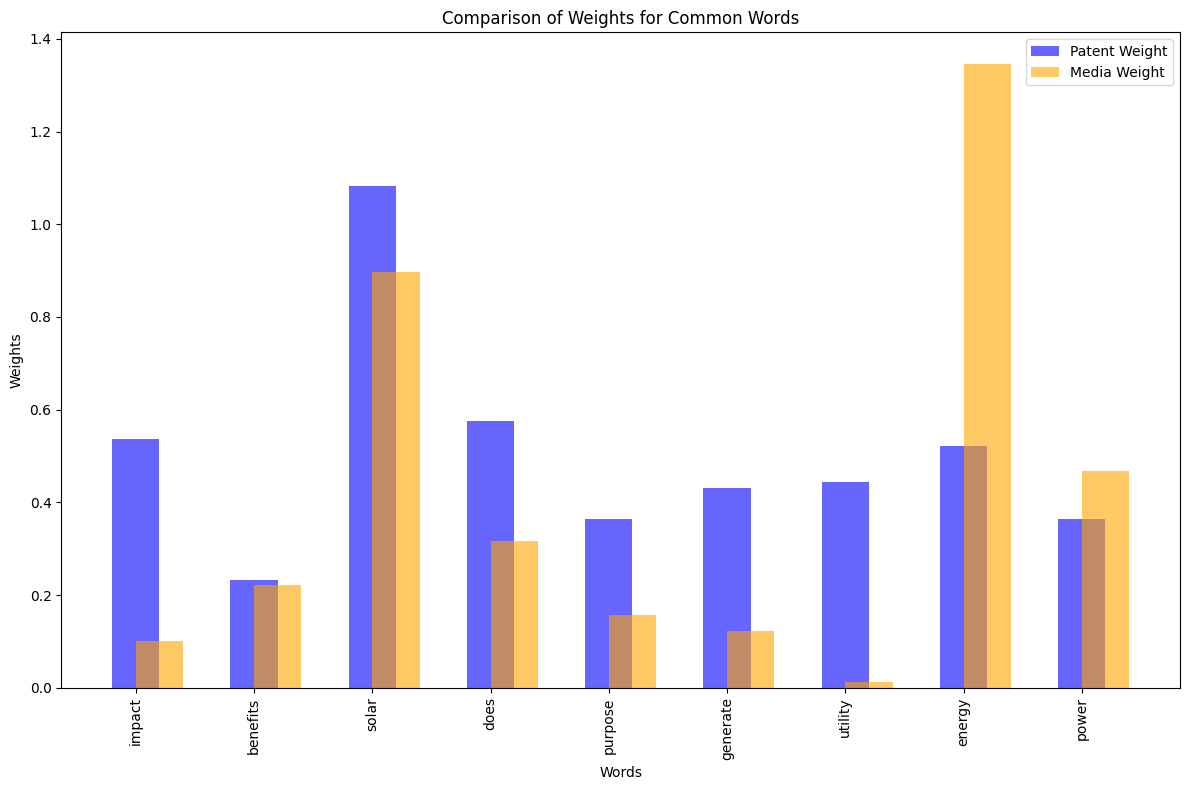

In [147]:
import matplotlib.pyplot as plt

def plot_common_word_weights(common_word_weights_df):
    # Set the size of the figure
    plt.figure(figsize=(12, 8))
    
    # Create a bar plot for each common word
    words = common_word_weights_df['word']
    patent_weights = common_word_weights_df['patent_weight']
    media_weights = common_word_weights_df['media_weight']
    
    x = range(len(words))  # Number of common words
    
    plt.bar(x, patent_weights, width=0.4, label='Patent Weight', align='center', alpha=0.6, color='blue')
    plt.bar(x, media_weights, width=0.4, label='Media Weight', align='edge', alpha=0.6, color='orange')
    
    plt.xlabel('Words')
    plt.ylabel('Weights')
    plt.title('Comparison of Weights for Common Words')
    plt.xticks(x, words, rotation='vertical')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the common word weights
plot_common_word_weights(common_word_weights_df)


It can be seen heere, that in the mediadata the energy and solar theme have a high weigth. Energy as a keyword is way higher than in the patent dataset. On the other hand in the patent dataset words like solar aand impact are way more important.

### Analyse the Patent dataset

In [148]:
def extract_weights_for_words(word_set, themes_df, num_words=None):
    weights_for_words = {}
    for word in word_set:
        for index, row in themes_df.iterrows():
            if word in row['top_words']:
                weights_for_words[word] = row['weights'][row['top_words'].index(word)]
                break  # Break once the word is found in a theme to avoid unnecessary iterations
    
    # Sort the dictionary by weight in descending order
    sorted_weights_for_words = {k: v for k, v in sorted(weights_for_words.items(), key=lambda item: item[1], reverse=True)}

    # If num_words is specified, return only the top num_words
    if num_words is not None:
        sorted_weights_for_words = dict(list(sorted_weights_for_words.items())[:num_words])

    return sorted_weights_for_words

# Extract weights for patent only top words
num_words_to_display = 20
patent_only_top_words_weights = extract_weights_for_words(patent_only_top_words, patent_themes_sklearn, num_words=num_words_to_display)

# Extract weights for media only top words
media_only_top_words_weights = extract_weights_for_words(media_only_top_words, media_themes_sklearn, num_words=num_words_to_display)

print(f"Top {num_words_to_display} Weights for Patent Only Top Words:")
for word, weight in patent_only_top_words_weights.items():
    print(f"{word}: Weight - {weight}")

print(f"\nTop {num_words_to_display} Weights for Media Only Top Words:")
for word, weight in media_only_top_words_weights.items():
    print(f"{word}: Weight - {weight}")

Top 20 Weights for Patent Only Top Words:
battery: Weight - 1.2555676527510309
water: Weight - 1.0419488761568922
protection: Weight - 1.00165989193507
set: Weight - 0.8202838524487504
box: Weight - 0.7468218013291106
equipment: Weight - 0.7416859879417389
model: Weight - 0.7083736829676424
main: Weight - 0.6918515439278491
generating: Weight - 0.6686483176314528
different: Weight - 0.5320942679397113
types: Weight - 0.5320942679397113
plants: Weight - 0.4876620576290394
transmission: Weight - 0.47735632753698537
electric: Weight - 0.4631724296657389
body: Weight - 0.4628325666975019
electricity: Weight - 0.4533136254337384
harness: Weight - 0.4533136254337384
assembly: Weight - 0.44504840259823153
waste: Weight - 0.4387936514551343
connected: Weight - 0.43871611070795985

Top 20 Weights for Media Only Top Words:
chinese: Weight - 1.4934404493310471
areas: Weight - 1.0951067208589824
lightsource: Weight - 1.0230085920383547
bp: Weight - 1.0230085920383547
projects: Weight - 0.887774032

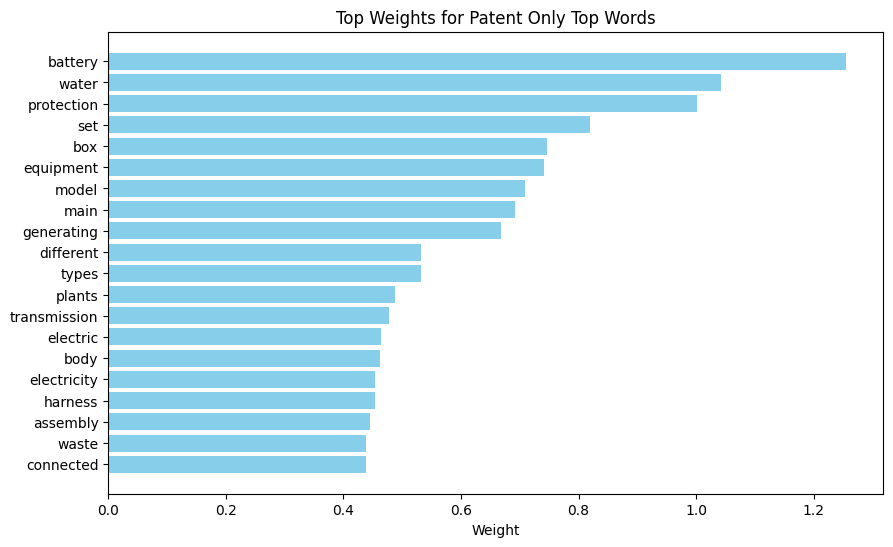

In [149]:
def plot_weights(weights_dict, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(range(len(weights_dict)), list(weights_dict.values()), align='center', color='skyblue')
    ax.set_yticks(range(len(weights_dict)))
    ax.set_yticklabels(list(weights_dict.keys()))
    ax.invert_yaxis()  # Invert y-axis to have highest weights on top
    ax.set_xlabel('Weight')
    ax.set_title(title)
    plt.show()

# Plot weights for patent only top words
plot_weights(patent_only_top_words_weights, 'Top Weights for Patent Only Top Words')



Above are shown the most important words, that were not in the media dataset. Here is an interpretation of the top 5 most important words:

- battery: A high weight for "battery" suggests that many patents discuss innovations or improvements related to battery technology. This could include battery composition, efficiency, storage capacity, and applications in various devices and industries.

- water: The term "water" indicates patents related to water technology, such as purification, desalination, distribution systems, or water conservation methods.

- protection: This word implies patents focusing on protective mechanisms, which could be physical (e.g., protective gear, coatings) or related to data security and privacy protection.

- set: The term "set" might be common in patents describing a collection of components or parts designed to work together, indicating modularity or kits.

- box: "Box" could refer to various types of enclosures or housings used in different applications, from electronic devices to packaging solutions.

### Analyse the Media dataset

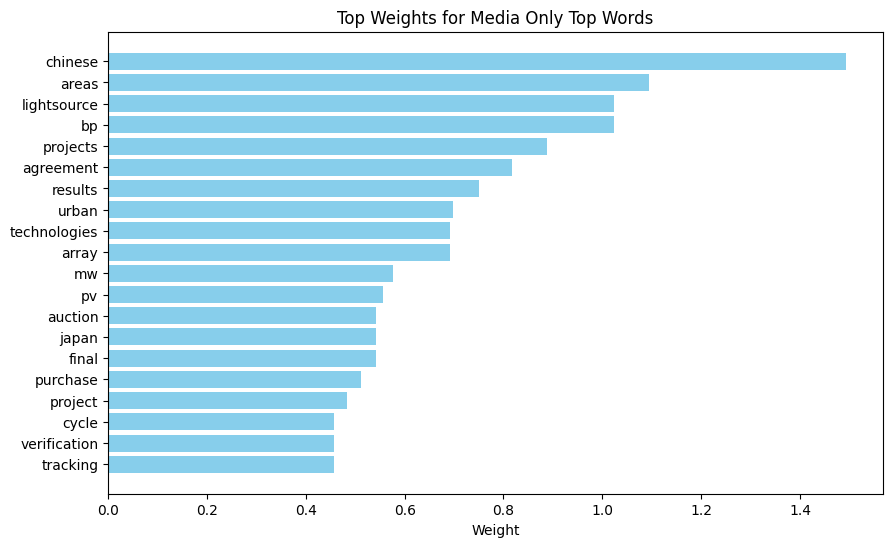

In [150]:
# Plot weights for media only top words
plot_weights(media_only_top_words_weights, 'Top Weights for Media Only Top Words')

Above are shown the most important words, that were not in the patent dataset. Here is an interpretation of the top 5 most important words:

- chinese: The highest weight for "chinese" suggests significant media coverage about China's role or influence in the context being studied. This could pertain to Chinese companies, policies, technological advancements, or international agreements involving China.

- areas: "Areas" implies discussions about specific regions or sectors, indicating that media often reports on geographical or thematic areas relevant to the topic.

- lightsource: The term "lightsource" may relate to discussions about lighting technology or companies specializing in lighting solutions.

- bp: "bp" likely refers to the British multinational oil and gas company BP, indicating media focus on their projects, investments, or environmental impact.

- projects: Frequent mention of "projects" suggests media coverage of various initiatives, construction efforts, or technological deployments.



### Final Conclusion

The patent dataset has a focus on practical, technical, and industrial innovations typical of patent documents. They indicate the importance of energy, water, protection mechanisms, equipment, assembly processes, and connectivity in the patent landscape. The high weights suggest these terms are central to the themes of the patents analyzed. In contrast the media data focus on projects, agreements, technological advancements, and the roles of different countries and companies. The high weights suggest that these terms are central to media discussions, highlighting the importance of international involvement, energy projects, and technological innovations.